In [1]:
import pandas as pd

data = pd.read_csv('data_sample_three_years.csv')

data = data.iloc[:, [0,1,2,3,4]]
data.rename(columns={'date': 'open', 'low':'close', 'open':'high', 'high':'low'}, inplace=True)

data['date'] = pd.to_datetime(data['timestamp'], unit='s')
data = data.iloc[:, [0,5,1,2,3,4]]

data_backup = data.loc[ data.timestamp >= 1675814400 ]
data = data.loc[ data.timestamp < 1675814400 ]

from talib import RSI
data['rsi_14'] = RSI(data['close'], timeperiod=14)
data['rsi_14'] = data['rsi_14'].shift(1)

from talib import MA, SMA, EMA, WMA
data['ma_9'] = MA(data['close'], timeperiod=9)
data['ma_9'] = data['ma_9'].shift(1)
data['sma_9'] = SMA(data['close'], timeperiod=9)
data['sma_9'] = data['sma_9'].shift(1)
data['wma_9'] = WMA(data['close'], timeperiod=9)
data['wma_9'] = data['wma_9'].shift(1)

from talib import MACD
data['macd'], data['signal'], data['hist'] = MACD(data['close'])
data['macd'] = data['macd'].shift(1)
data['signal'] = data['signal'].shift(1)
data['hist'] = data['hist'].shift(1)

from talib import ADX
data['adx'] = ADX(data['high'], data['low'], data['close'])
data['adx'] = data['adx'].shift(1)

from talib import ATR
data['atr'] = ATR(high=data['high'], low=data['low'], close=data['close'], timeperiod=14)
data['atr'] = data['atr'].shift(1)

from talib import SAR
data['sar'] = SAR(high=data['high'], low=data['low'], acceleration=0.02, maximum=0.2)
data['sar'] = data['sar'].shift(1)

from talib import TEMA
data['tema'] = TEMA(data['close'], timeperiod=14)
data['tema'] = data['tema'].shift(1)

from talib import ROC
data['roc'] = ROC(data['close'], timeperiod=14)
data['roc'] = data['roc'].shift(1)

data.dropna(axis=0, inplace=True)

In [2]:
data['close+1'] = data['close'].shift(1)
data['close+2'] = data['close'].shift(2)
data['close+3'] = data['close'].shift(3)
data['close+4'] = data['close'].shift(4)
data['close+5'] = data['close'].shift(5)

data['close_roc'] = ( data['close'] - data['close'].shift(1) ) / data['close'].shift(1)
data['close_roc'] = data['close_roc'].shift(1)
data['rsi_14_roc'] = ( data['rsi_14'] - data['rsi_14'].shift(1) ) / data['rsi_14'].shift(1)
data['rsi_14_roc'] = data['rsi_14_roc'].shift(1)
data['ma_9_roc'] = ( data['ma_9'] - data['ma_9'].shift(1) ) / data['ma_9'].shift(1)
data['ma_9_roc'] = data['ma_9_roc'].shift(1)

data['close_roll'] = data['close+1'].rolling(window=14).mean()
data['rsi_14_roll'] = data['rsi_14'].rolling(window=14).mean()
data['ma_9_roll'] = data['ma_9'].rolling(window=14).mean()

data.dropna(axis=0, inplace=True)

In [3]:
data.shape

(16208, 29)

In [4]:
best_features = ('ma_9', 'wma_9', 'macd', 'signal', 'hist', 'adx', 'atr', 'sar', 'tema', 'roc', 'close+1', 'close+2', 'close+3', 'close+4', 'close+5', 'close_roc', 'rsi_14_roc', 'ma_9_roc', 'close_roll', 'rsi_14_roll', 'ma_9_roll')

In [5]:
data.columns

Index(['timestamp', 'date', 'open', 'high', 'low', 'close', 'rsi_14', 'ma_9',
       'sma_9', 'wma_9', 'macd', 'signal', 'hist', 'adx', 'atr', 'sar', 'tema',
       'roc', 'close+1', 'close+2', 'close+3', 'close+4', 'close+5',
       'close_roc', 'rsi_14_roc', 'ma_9_roc', 'close_roll', 'rsi_14_roll',
       'ma_9_roll'],
      dtype='object')

In [6]:
inputs = data[list(best_features)]
target = data.iloc[:, [5]]

In [7]:
import pandas as pd
import numpy as np
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.2, random_state=1, shuffle=False)

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2024-03-12 06:32:15.689414: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 06:32:15.763506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 06:32:15.763575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 06:32:15.767076: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 06:32:15.781631: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 06:32:17.432512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

In [9]:
# Define and train the LSTM model
model = Sequential([
    Dense(64, activation='softplus', input_shape=(len(best_features),)),  # Input layer with 10 features
    Dense(64, activation='softplus'),                     # Hidden layer with 64 units
    Dense(1)                                          # Output layer with 1 unit for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse')  # Using Mean Squared Error loss for regression

# Train the model
model.fit(X_train, y_train, epochs=500, batch_size=32)

Epoch 1/500
406/406 [==============================] - 2s 3ms/step - loss: 481445.8438
Epoch 2/500
406/406 [==============================] - 1s 3ms/step - loss: 1962.9551
Epoch 3/500
406/406 [==============================] - 1s 2ms/step - loss: 1601.4132
Epoch 4/500
406/406 [==============================] - 1s 3ms/step - loss: 1462.4771
Epoch 5/500
406/406 [==============================] - 1s 2ms/step - loss: 1427.3719
Epoch 6/500
406/406 [==============================] - 1s 2ms/step - loss: 1443.4542
Epoch 7/500
406/406 [==============================] - 1s 3ms/step - loss: 1316.3411
Epoch 8/500
406/406 [==============================] - 1s 3ms/step - loss: 1347.5801
Epoch 9/500
406/406 [==============================] - 1s 3ms/step - loss: 1301.2135
Epoch 10/500
406/406 [==============================] - 1s 3ms/step - loss: 1460.2035
Epoch 11/500
406/406 [==============================] - 1s 2ms/step - loss: 1339.5775
Epoch 12/500
406/406 [==============================] - 1s 2m

In [10]:
y_pred = model.predict(X_test)
score = mean_squared_error(y_test['close'], y_pred)

y_test['pred'] = y_pred

102/102 [==============================] - 0s 2ms/step


In [11]:
print(score)

111.10533378180793


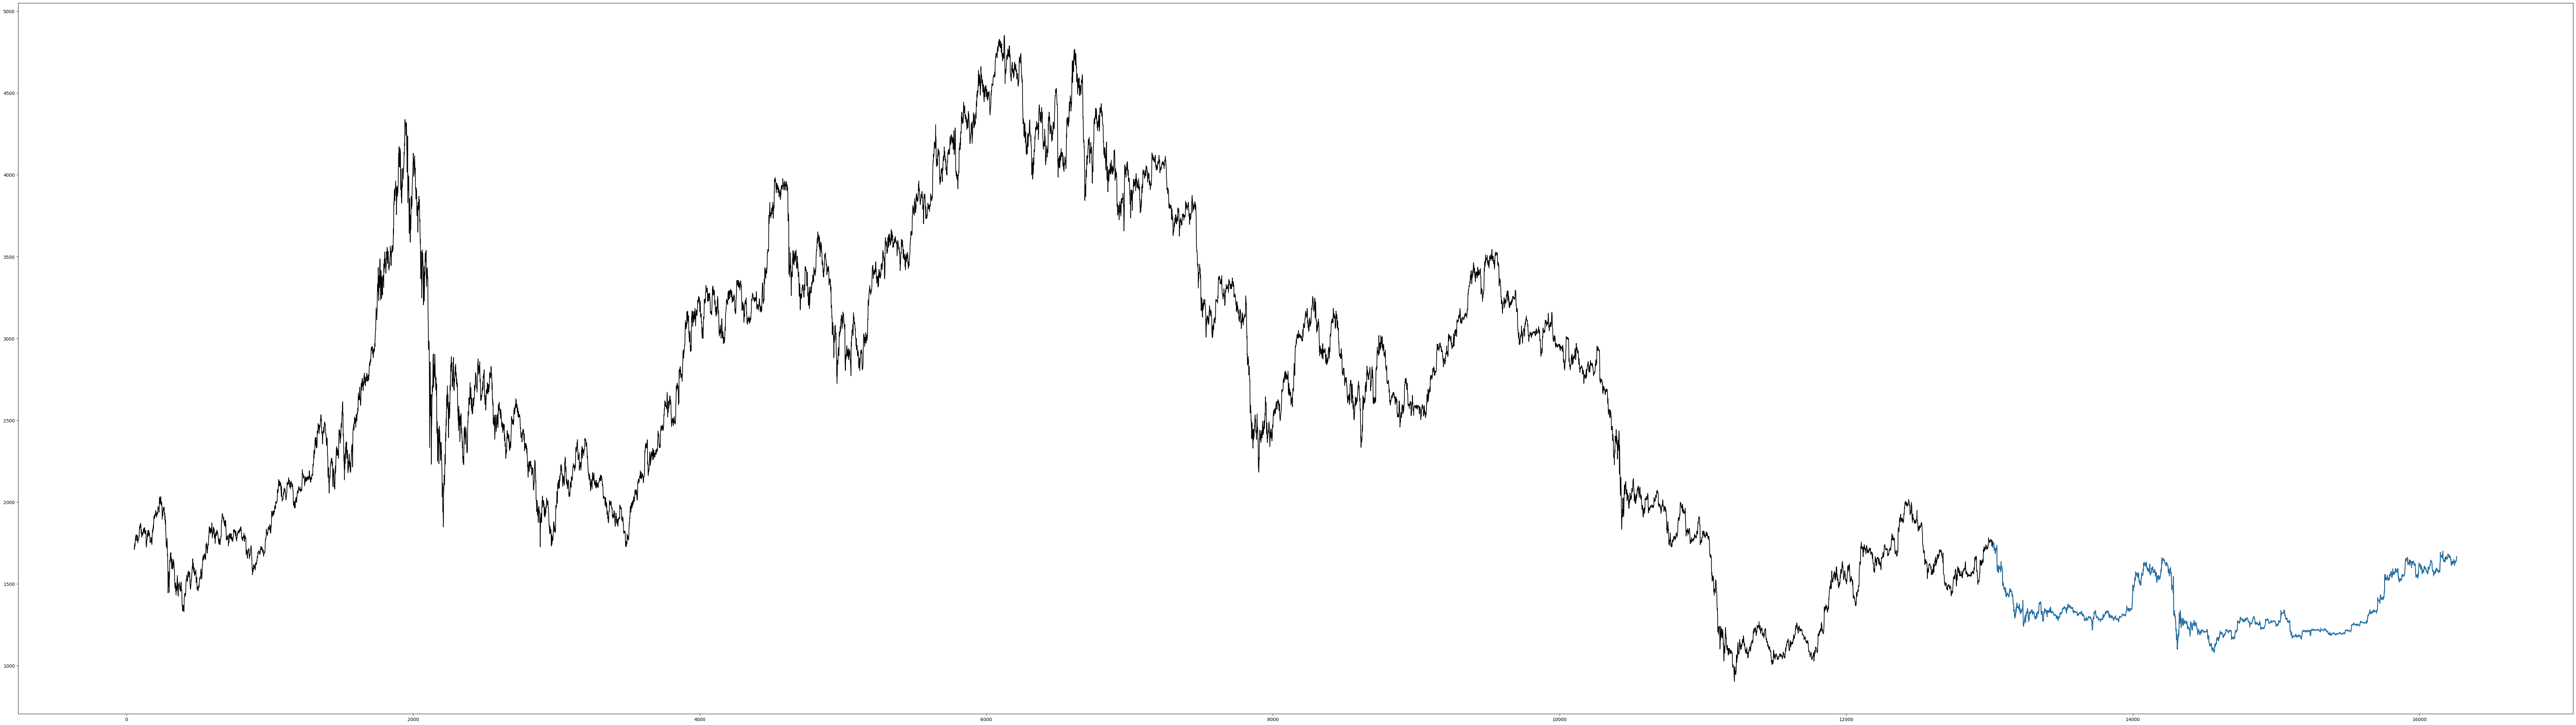

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(100, 28))

plt.plot(data['close'], color='black')
plt.plot(y_test['pred'])
plt.show()